# Bölüm 1: Gerekli Paketlerin Kurulması ve Uyarıların Kapatılması

Açıklama:
Bu hücrede, projede kullanacağımız kütüphanelerin (sadece ilk sefer çalıştırıldığında) kurulması için gerekli pip install komutları yer alıyor. Sadece gereksiz uyarılar kapatılır.


In [1]:
!pip install --no-cache-dir scipy==1.11.3
!pip install --no-cache-dir xgboost==2.1.3
!pip install --no-cache-dir scikit-learn==1.3.0
!pip install --no-cache-dir tsfresh==0.20.0
!pip install --no-cache-dir numpy pandas matplotlib seaborn requests yfinance catboost pandas_ta
!pip install --no-cache-dir imbalanced-learn

import warnings
import os
warnings.simplefilter(action='ignore', category=FutureWarning)  # FutureWarning'leri kapatır
warnings.simplefilter(action='ignore', category=UserWarning)    # UserWarning'leri kapatır
warnings.simplefilter(action='ignore', category=DeprecationWarning)  # Eski fonksiyon uyarılarını kapatır
warnings.simplefilter(action='ignore', category=RuntimeWarning)  # Runtime uyarılarını kapatır


os.environ["PYTHONWARNINGS"] = "ignore"  # Genel olarak tüm uyarıları kapatır

print("🚀 Tüm gereksiz uyarılar kapatıldı!")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 129.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 11.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.0 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.3.0 which is incompatible.
INFO: pip is looking at multiple versions of d

# Bölüm 2: Gerekli Kütüphanelerin İçe Aktarılması
Açıklama:
Projede kullanacağımız temel kütüphaneleri içe aktarıyoruz.

In [2]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import yfinance as yf
import tsfresh
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import impute
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
import pandas_ta as ta
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

print("✅ Tüm kütüphaneler başarıyla yüklendi ve içe aktarıldı!")


✅ Tüm kütüphaneler başarıyla yüklendi ve içe aktarıldı!


# Bölüm 3: Yüklü Paket Sürümlerinin Kontrolü
Açıklama:
Bu hücrede, temel paketlerin (scipy, tsfresh, scikit-learn) sürümlerini kontrol ediyoruz.

In [3]:
import scipy
import sklearn

print("🔍 Paket Sürümleri:")
print(f"🔹 scipy: {scipy.__version__}")
print(f"🔹 tsfresh: {tsfresh.__version__}")
print(f"🔹 scikit-learn: {sklearn.__version__}")
print("🚀 Ortam hazır. Kodlar çalıştırılabilir.\n")


🔍 Paket Sürümleri:
🔹 scipy: 1.11.3
🔹 tsfresh: 0.20.0
🔹 scikit-learn: 1.6.1
🚀 Ortam hazır. Kodlar çalıştırılabilir.



# Bölüm 4: Klasör Yapısının Oluşturulması
Açıklama:
Verilerin kaydedileceği klasörleri oluşturuyoruz.

In [4]:
folders = ["data/stock_sectors"]
for folder in folders:
    os.makedirs(folder, exist_ok=True)
    print(f"'{folder}' klasörü oluşturuldu veya zaten mevcut.")


'data/stock_sectors' klasörü oluşturuldu veya zaten mevcut.


# Bölüm 5: Web Scraping – Sektör ve Endüstri Verilerinin Çekilmesi
Açıklama:
Web'den sektör isimlerini ve örnek sektör verilerini çekmek için fonksiyonlar tanımlanıyor ve çalıştırılıyor. Sonrasında CSV dosyalarına kaydediliyor.

In [5]:
def fetch_sectors_names():
    """
    Sektör isimlerini içeren tabloyu web üzerinden çekip DataFrame olarak döndürür.
    """
    url = "https://stockanalysis.com/stocks/industry/sectors/"
    try:
        response = requests.get(url)
        response.raise_for_status()
        tables = pd.read_html(response.text)
        if tables:
            df = tables[0]
            print("Sektör isimleri başarıyla çekildi.")
            return df
        else:
            print("Tablo bulunamadı.")
            return pd.DataFrame()
    except Exception as e:
        print(f"fetch_sectors_names hatası: {e}")
        return pd.DataFrame()

def fetch_data(category, name):
    """
    Belirtilen kategori ve isim için web üzerinden verileri çekip DataFrame olarak döndürür.
    """
    url = f"https://stockanalysis.com/stocks/{category}/{name}/"
    try:
        response = requests.get(url)
        response.raise_for_status()
        tables = pd.read_html(response.text)
        if tables:
            df = tables[0]
            print(f"{name.capitalize()} {category} verisi başarıyla çekildi.")
            return df
        else:
            print(f"{name.capitalize()} {category} verisi için tablo bulunamadı.")
            return pd.DataFrame()
    except Exception as e:
        print(f"{name.capitalize()} {category} verisi çekilirken hata: {e}")
        return pd.DataFrame()

# Sektör isimlerini çekip CSV'ye kaydetme
sectors_df = fetch_sectors_names()
print(sectors_df.head(), "\n")
sectors_df.to_csv("data/stock_sectors/sectors_sample.csv", index=False)

# Finans, Sağlık ve Teknoloji
financials_df = fetch_data("sector", "financials")
if not financials_df.empty:
    financials_df.to_csv("data/stock_sectors/financials.csv", index=False)

healthcare_df = fetch_data("sector", "healthcare")
if not healthcare_df.empty:
    healthcare_df.to_csv("data/stock_sectors/healthcare.csv", index=False)

technology_df = fetch_data("sector", "technology")
if not technology_df.empty:
    technology_df.to_csv("data/stock_sectors/technology.csv", index=False)


Sektör isimleri başarıyla çekildi.
              Sector Name  Stocks Market Cap Div. Yield  PE Ratio  \
0              Financials    1311     12.07T      0.17%     15.89   
1              Healthcare    1191  8,050.26B      0.50%     64.47   
2              Technology     806     22.15T      0.48%     47.98   
3             Industrials     688  5,919.76B      1.19%     30.21   
4  Consumer Discretionary     573  8,913.72B      0.76%     30.08   

  Profit Margin 1D Change 1Y Change  
0        20.18%     0.92%    35.53%  
1         2.94%     0.51%    10.16%  
2        14.32%     1.58%    48.75%  
3         7.03%     0.10%    24.06%  
4         6.46%     1.71%    36.24%   

Financials sector verisi başarıyla çekildi.
Healthcare sector verisi başarıyla çekildi.
Technology sector verisi başarıyla çekildi.


# Bölüm 6: YFinance ile Tarihsel Verilerin Toplanması (2005'ten Günümüze)
Açıklama:
Belirtilen sektörlerde yer alan sembollerin 2005'ten itibaren tarihsel verilerini yfinance kütüphanesi ile çekiyoruz ve CSV’ye kaydediyoruz.

In [6]:
def fetch_historical_data_for_sector(sector_name, filename):
    """
    Belirtilen sektörün sembollerine ait 2005'ten itibaren tarihsel verileri çeker.
    """
    filepath = f"data/stock_sectors/{filename}"
    if not os.path.exists(filepath):
        print(f"{filepath} bulunamadı!")
        return pd.DataFrame()
    sector_df = pd.read_csv(filepath)
    if "Symbol" not in sector_df.columns:
        print("CSV dosyasında 'Symbol' sütunu bulunamadı!")
        return pd.DataFrame()
    symbols = sector_df["Symbol"].dropna().unique()
    master_data = pd.DataFrame()
    for symbol in symbols:
        try:
            print(f"{symbol} için tarihsel veri çekiliyor... (Sektör: {sector_name})")
            ticker = yf.Ticker(symbol)
            df_hist = ticker.history(start='2005-01-01')
            if df_hist.empty:
                print(f"{symbol} için veri bulunamadı.")
                continue
            df_hist.reset_index(inplace=True)
            df_hist["Symbol"] = symbol
            df_hist["Sector"] = sector_name
            master_data = pd.concat([master_data, df_hist], ignore_index=True)
            time.sleep(0.2) # API UYARI VERMEMESİ İÇİN KONULDU.
        except Exception as e:
            print(f"{symbol} için veri çekilirken hata: {e}")
    return master_data

financials_data = fetch_historical_data_for_sector("financials", "financials.csv")
financials_data.to_csv("data/stock_sectors/financials_historical.csv", index=False)
print("Financials sektör tarihsel verisi kaydedildi.\n")

healthcare_data = fetch_historical_data_for_sector("healthcare", "healthcare.csv")
healthcare_data.to_csv("data/stock_sectors/healthcare_historical.csv", index=False)
print("Healthcare sektör tarihsel verisi kaydedildi.\n")

technology_data = fetch_historical_data_for_sector("technology", "technology.csv")
technology_data.to_csv("data/stock_sectors/technology_historical.csv", index=False)
print("Technology sektör tarihsel verisi kaydedildi.\n")


BRK.B için tarihsel veri çekiliyor... (Sektör: financials)


ERROR:yfinance:$BRK.B: possibly delisted; no timezone found


BRK.B için veri bulunamadı.
JPM için tarihsel veri çekiliyor... (Sektör: financials)
V için tarihsel veri çekiliyor... (Sektör: financials)
MA için tarihsel veri çekiliyor... (Sektör: financials)
BAC için tarihsel veri çekiliyor... (Sektör: financials)
WFC için tarihsel veri çekiliyor... (Sektör: financials)
MS için tarihsel veri çekiliyor... (Sektör: financials)
AXP için tarihsel veri çekiliyor... (Sektör: financials)
GS için tarihsel veri çekiliyor... (Sektör: financials)
BX için tarihsel veri çekiliyor... (Sektör: financials)
HSBC için tarihsel veri çekiliyor... (Sektör: financials)
RY için tarihsel veri çekiliyor... (Sektör: financials)
SPGI için tarihsel veri çekiliyor... (Sektör: financials)
C için tarihsel veri çekiliyor... (Sektör: financials)
PGR için tarihsel veri çekiliyor... (Sektör: financials)
BLK için tarihsel veri çekiliyor... (Sektör: financials)
HDB için tarihsel veri çekiliyor... (Sektör: financials)
SCHW için tarihsel veri çekiliyor... (Sektör: financials)
MUFG için

ERROR:yfinance:$AGM.A: possibly delisted; no timezone found


AGM.A için veri bulunamadı.
CIFR için tarihsel veri çekiliyor... (Sektör: financials)
CIFRW için tarihsel veri çekiliyor... (Sektör: financials)
TSLX için tarihsel veri çekiliyor... (Sektör: financials)
ROOT için tarihsel veri çekiliyor... (Sektör: financials)
TRUP için tarihsel veri çekiliyor... (Sektör: financials)
HTH için tarihsel veri çekiliyor... (Sektör: financials)
SKWD için tarihsel veri çekiliyor... (Sektör: financials)
PWP için tarihsel veri çekiliyor... (Sektör: financials)
OFG için tarihsel veri çekiliyor... (Sektör: financials)
PAX için tarihsel veri çekiliyor... (Sektör: financials)
MBIN için tarihsel veri çekiliyor... (Sektör: financials)
PSEC için tarihsel veri çekiliyor... (Sektör: financials)
HUT için tarihsel veri çekiliyor... (Sektör: financials)
HG için tarihsel veri çekiliyor... (Sektör: financials)
CASH için tarihsel veri çekiliyor... (Sektör: financials)
DBRG için tarihsel veri çekiliyor... (Sektör: financials)
STC için tarihsel veri çekiliyor... (Sektör: finan

ERROR:yfinance:$AACT.WS: possibly delisted; no timezone found


AACT.WS için veri bulunamadı.
LPRO için tarihsel veri çekiliyor... (Sektör: financials)
VINP için tarihsel veri çekiliyor... (Sektör: financials)
SMBC için tarihsel veri çekiliyor... (Sektör: financials)
UFCS için tarihsel veri çekiliyor... (Sektör: financials)
MOFG için tarihsel veri çekiliyor... (Sektör: financials)
ESQ için tarihsel veri çekiliyor... (Sektör: financials)
AMRK için tarihsel veri çekiliyor... (Sektör: financials)
FSBC için tarihsel veri çekiliyor... (Sektör: financials)
BITF için tarihsel veri çekiliyor... (Sektör: financials)
OPY için tarihsel veri çekiliyor... (Sektör: financials)
ORRF için tarihsel veri çekiliyor... (Sektör: financials)
HTBK için tarihsel veri çekiliyor... (Sektör: financials)
HTBI için tarihsel veri çekiliyor... (Sektör: financials)
CION için tarihsel veri çekiliyor... (Sektör: financials)
TRST için tarihsel veri çekiliyor... (Sektör: financials)
GLAD için tarihsel veri çekiliyor... (Sektör: financials)
CCBG için tarihsel veri çekiliyor... (Sektör

ERROR:yfinance:$CRD.A: possibly delisted; no timezone found


CRD.A için veri bulunamadı.
UVE için tarihsel veri çekiliyor... (Sektör: financials)
FISI için tarihsel veri çekiliyor... (Sektör: financials)
CRD.B için tarihsel veri çekiliyor... (Sektör: financials)


ERROR:yfinance:$CRD.B: possibly delisted; no timezone found


CRD.B için veri bulunamadı.
MPB için tarihsel veri çekiliyor... (Sektör: financials)
YRD için tarihsel veri çekiliyor... (Sektör: financials)
QD için tarihsel veri çekiliyor... (Sektör: financials)
AMBC için tarihsel veri çekiliyor... (Sektör: financials)
INV için tarihsel veri çekiliyor... (Sektör: financials)
SHBI için tarihsel veri çekiliyor... (Sektör: financials)
CCNE için tarihsel veri çekiliyor... (Sektör: financials)
ALRS için tarihsel veri çekiliyor... (Sektör: financials)
FMNB için tarihsel veri çekiliyor... (Sektör: financials)
BCAL için tarihsel veri çekiliyor... (Sektör: financials)
CBNK için tarihsel veri çekiliyor... (Sektör: financials)
EBTC için tarihsel veri çekiliyor... (Sektör: financials)
LDI için tarihsel veri çekiliyor... (Sektör: financials)
TCBX için tarihsel veri çekiliyor... (Sektör: financials)
DGICA için tarihsel veri çekiliyor... (Sektör: financials)
PFIS için tarihsel veri çekiliyor... (Sektör: financials)
PSBD için tarihsel veri çekiliyor... (Sektör: fin

ERROR:yfinance:$EQV.WS: possibly delisted; no timezone found


EQV.WS için veri bulunamadı.
FBIZ için tarihsel veri çekiliyor... (Sektör: financials)
VBNK için tarihsel veri çekiliyor... (Sektör: financials)
HIVE için tarihsel veri çekiliyor... (Sektör: financials)
ITIC için tarihsel veri çekiliyor... (Sektör: financials)
BSRR için tarihsel veri çekiliyor... (Sektör: financials)
FFWM için tarihsel veri çekiliyor... (Sektör: financials)
RWAY için tarihsel veri çekiliyor... (Sektör: financials)
MSBI için tarihsel veri çekiliyor... (Sektör: financials)
NETDW için tarihsel veri çekiliyor... (Sektör: financials)
NETD için tarihsel veri çekiliyor... (Sektör: financials)
GOCO için tarihsel veri çekiliyor... (Sektör: financials)
CARE için tarihsel veri çekiliyor... (Sektör: financials)
MFH için tarihsel veri çekiliyor... (Sektör: financials)
SCM için tarihsel veri çekiliyor... (Sektör: financials)
BWB için tarihsel veri çekiliyor... (Sektör: financials)
BZAI için tarihsel veri çekiliyor... (Sektör: financials)
BSVN için tarihsel veri çekiliyor... (Sektör:

ERROR:yfinance:$KFII: possibly delisted; no timezone found


KFII için veri bulunamadı.
CIVB için tarihsel veri çekiliyor... (Sektör: financials)
GIG için tarihsel veri çekiliyor... (Sektör: financials)
NEWT için tarihsel veri çekiliyor... (Sektör: financials)
CZNC için tarihsel veri çekiliyor... (Sektör: financials)
SSBK için tarihsel veri çekiliyor... (Sektör: financials)
PMTS için tarihsel veri çekiliyor... (Sektör: financials)
VALU için tarihsel veri çekiliyor... (Sektör: financials)
BRBS için tarihsel veri çekiliyor... (Sektör: financials)
HIT için tarihsel veri çekiliyor... (Sektör: financials)
HYAC için tarihsel veri çekiliyor... (Sektör: financials)
HYAC.WS için tarihsel veri çekiliyor... (Sektör: financials)


ERROR:yfinance:$HYAC.WS: possibly delisted; no timezone found


HYAC.WS için veri bulunamadı.
VACH için tarihsel veri çekiliyor... (Sektör: financials)
VACHW için tarihsel veri çekiliyor... (Sektör: financials)
BEAG için tarihsel veri çekiliyor... (Sektör: financials)
RBB için tarihsel veri çekiliyor... (Sektör: financials)
FLIC için tarihsel veri çekiliyor... (Sektör: financials)
TPVG için tarihsel veri çekiliyor... (Sektör: financials)
CUB için tarihsel veri çekiliyor... (Sektör: financials)
BCML için tarihsel veri çekiliyor... (Sektör: financials)
SIMA için tarihsel veri çekiliyor... (Sektör: financials)
SIMAW için tarihsel veri çekiliyor... (Sektör: financials)
EHTH için tarihsel veri çekiliyor... (Sektör: financials)
CBAN için tarihsel veri çekiliyor... (Sektör: financials)
SNFCA için tarihsel veri çekiliyor... (Sektör: financials)
DRDB için tarihsel veri çekiliyor... (Sektör: financials)
DRDBW için tarihsel veri çekiliyor... (Sektör: financials)
PDLB için tarihsel veri çekiliyor... (Sektör: financials)
PBFS için tarihsel veri çekiliyor... (Se

ERROR:yfinance:$JACS.RT: possibly delisted; no timezone found


JACS.RT için veri bulunamadı.
SFST için tarihsel veri çekiliyor... (Sektör: financials)
COFS için tarihsel veri çekiliyor... (Sektör: financials)
PCB için tarihsel veri çekiliyor... (Sektör: financials)
GRAF için tarihsel veri çekiliyor... (Sektör: financials)
LPAA için tarihsel veri çekiliyor... (Sektör: financials)
LPAAW için tarihsel veri çekiliyor... (Sektör: financials)
HOND için tarihsel veri çekiliyor... (Sektör: financials)
HONDW için tarihsel veri çekiliyor... (Sektör: financials)
GSRT için tarihsel veri çekiliyor... (Sektör: financials)
LPBBW için tarihsel veri çekiliyor... (Sektör: financials)
LPBB için tarihsel veri çekiliyor... (Sektör: financials)
INBK için tarihsel veri çekiliyor... (Sektör: financials)
FNLC için tarihsel veri çekiliyor... (Sektör: financials)
ONIT için tarihsel veri çekiliyor... (Sektör: financials)
NECB için tarihsel veri çekiliyor... (Sektör: financials)
MLAC için tarihsel veri çekiliyor... (Sektör: financials)
JMSB için tarihsel veri çekiliyor... (Se

ERROR:yfinance:$AACB: possibly delisted; no price data found  (1d 2005-01-01 -> 2025-02-14)


AACB için tarihsel veri çekiliyor... (Sektör: financials)
AACB için veri bulunamadı.
SAMG için tarihsel veri çekiliyor... (Sektör: financials)
WHF için tarihsel veri çekiliyor... (Sektör: financials)
HWBK için tarihsel veri çekiliyor... (Sektör: financials)
SBT için tarihsel veri çekiliyor... (Sektör: financials)
CHMG için tarihsel veri çekiliyor... (Sektör: financials)
TSBK için tarihsel veri çekiliyor... (Sektör: financials)
FACT için tarihsel veri çekiliyor... (Sektör: financials)
FACTW için tarihsel veri çekiliyor... (Sektör: financials)
EVBN için tarihsel veri çekiliyor... (Sektör: financials)
NTWOW için tarihsel veri çekiliyor... (Sektör: financials)
NTWO için tarihsel veri çekiliyor... (Sektör: financials)
NWFL için tarihsel veri çekiliyor... (Sektör: financials)
BWFG için tarihsel veri çekiliyor... (Sektör: financials)
CPSS için tarihsel veri çekiliyor... (Sektör: financials)
PWOD için tarihsel veri çekiliyor... (Sektör: financials)
PKBK için tarihsel veri çekiliyor... (Sektör:

ERROR:yfinance:$CLBR.WS: possibly delisted; no timezone found


CLBR.WS için veri bulunamadı.
CLBR için tarihsel veri çekiliyor... (Sektör: financials)
OPRT için tarihsel veri çekiliyor... (Sektör: financials)
OVLY için tarihsel veri çekiliyor... (Sektör: financials)
FBLA için tarihsel veri çekiliyor... (Sektör: financials)
FVCB için tarihsel veri çekiliyor... (Sektör: financials)
ESSA için tarihsel veri çekiliyor... (Sektör: financials)
KINS için tarihsel veri çekiliyor... (Sektör: financials)
MACI için tarihsel veri çekiliyor... (Sektör: financials)
LCNB için tarihsel veri çekiliyor... (Sektör: financials)
BPRN için tarihsel veri çekiliyor... (Sektör: financials)
SVCC için tarihsel veri çekiliyor... (Sektör: financials)


ERROR:yfinance:$SVCC: possibly delisted; no timezone found


SVCC için veri bulunamadı.
KVAC için tarihsel veri çekiliyor... (Sektör: financials)
TDAC için tarihsel veri çekiliyor... (Sektör: financials)
OPBK için tarihsel veri çekiliyor... (Sektör: financials)
DYNXW için tarihsel veri çekiliyor... (Sektör: financials)
DYNX için tarihsel veri çekiliyor... (Sektör: financials)
PVBC için tarihsel veri çekiliyor... (Sektör: financials)
MBCN için tarihsel veri çekiliyor... (Sektör: financials)
FCCO için tarihsel veri çekiliyor... (Sektör: financials)
ATII için tarihsel veri çekiliyor... (Sektör: financials)


ERROR:yfinance:$ATII: possibly delisted; no timezone found


ATII için veri bulunamadı.
DMAA için tarihsel veri çekiliyor... (Sektör: financials)


ERROR:yfinance:$DMAA: possibly delisted; no timezone found


DMAA için veri bulunamadı.
SWKH için tarihsel veri çekiliyor... (Sektör: financials)
BLFY için tarihsel veri çekiliyor... (Sektör: financials)
MYFW için tarihsel veri çekiliyor... (Sektör: financials)
MKTW için tarihsel veri çekiliyor... (Sektör: financials)
VABK için tarihsel veri çekiliyor... (Sektör: financials)
WNEB için tarihsel veri çekiliyor... (Sektör: financials)
FFNW için tarihsel veri çekiliyor... (Sektör: financials)
HMST için tarihsel veri çekiliyor... (Sektör: financials)
OXSQ için tarihsel veri çekiliyor... (Sektör: financials)
BSIIW için tarihsel veri çekiliyor... (Sektör: financials)
BSII için tarihsel veri çekiliyor... (Sektör: financials)
EARN için tarihsel veri çekiliyor... (Sektör: financials)
HNVR için tarihsel veri çekiliyor... (Sektör: financials)
ISTR için tarihsel veri çekiliyor... (Sektör: financials)
MFIN için tarihsel veri çekiliyor... (Sektör: financials)
MRBK için tarihsel veri çekiliyor... (Sektör: financials)
MRCC için tarihsel veri çekiliyor... (Sektör

ERROR:yfinance:$MAYA: possibly delisted; no timezone found


MAYA için veri bulunamadı.
FNWB için tarihsel veri çekiliyor... (Sektör: financials)
BSBK için tarihsel veri çekiliyor... (Sektör: financials)
PFX için tarihsel veri çekiliyor... (Sektör: financials)
AFJK için tarihsel veri çekiliyor... (Sektör: financials)
MHLD için tarihsel veri çekiliyor... (Sektör: financials)
IPXX için tarihsel veri çekiliyor... (Sektör: financials)
DGHI için tarihsel veri çekiliyor... (Sektör: financials)
GLAC için tarihsel veri çekiliyor... (Sektör: financials)
MGYR için tarihsel veri çekiliyor... (Sektör: financials)
QETA için tarihsel veri çekiliyor... (Sektör: financials)
HNNA için tarihsel veri çekiliyor... (Sektör: financials)
IVCA için tarihsel veri çekiliyor... (Sektör: financials)
NOEM için tarihsel veri çekiliyor... (Sektör: financials)
DYCQ için tarihsel veri çekiliyor... (Sektör: financials)
BKHA için tarihsel veri çekiliyor... (Sektör: financials)
IROH için tarihsel veri çekiliyor... (Sektör: financials)
HSPO için tarihsel veri çekiliyor... (Sektör: 

ERROR:yfinance:$RIBB: possibly delisted; no timezone found


RIBB için veri bulunamadı.
BYFC için tarihsel veri çekiliyor... (Sektör: financials)
COLA için tarihsel veri çekiliyor... (Sektör: financials)


ERROR:yfinance:$COLA: possibly delisted; no timezone found


COLA için veri bulunamadı.
CPBI için tarihsel veri çekiliyor... (Sektör: financials)
NSTS için tarihsel veri çekiliyor... (Sektör: financials)
MDBH için tarihsel veri çekiliyor... (Sektör: financials)
GBBK için tarihsel veri çekiliyor... (Sektör: financials)
FTII için tarihsel veri çekiliyor... (Sektör: financials)
BOTJ için tarihsel veri çekiliyor... (Sektör: financials)
BAYA için tarihsel veri çekiliyor... (Sektör: financials)
SDIG için tarihsel veri çekiliyor... (Sektör: financials)
WAI için tarihsel veri çekiliyor... (Sektör: financials)
PLUT için tarihsel veri çekiliyor... (Sektör: financials)
BUJA için tarihsel veri çekiliyor... (Sektör: financials)
OPHC için tarihsel veri çekiliyor... (Sektör: financials)
GEG için tarihsel veri çekiliyor... (Sektör: financials)
BCOW için tarihsel veri çekiliyor... (Sektör: financials)
CLRC için tarihsel veri çekiliyor... (Sektör: financials)
COHN için tarihsel veri çekiliyor... (Sektör: financials)
EMCG için tarihsel veri çekiliyor... (Sektör: f

ERROR:yfinance:Could not get exchangeTimezoneName for ticker 'RDY' reason: 'chart'
ERROR:yfinance:$RDY: possibly delisted; no timezone found


RDY için veri bulunamadı.
GMED için tarihsel veri çekiliyor... (Sektör: healthcare)
SNN için tarihsel veri çekiliyor... (Sektör: healthcare)
TECH için tarihsel veri çekiliyor... (Sektör: healthcare)
PEN için tarihsel veri çekiliyor... (Sektör: healthcare)
SRPT için tarihsel veri çekiliyor... (Sektör: healthcare)
PCVX için tarihsel veri çekiliyor... (Sektör: healthcare)
MEDP için tarihsel veri çekiliyor... (Sektör: healthcare)
EHC için tarihsel veri çekiliyor... (Sektör: healthcare)
HQY için tarihsel veri çekiliyor... (Sektör: healthcare)
HSIC için tarihsel veri çekiliyor... (Sektör: healthcare)
EXEL için tarihsel veri çekiliyor... (Sektör: healthcare)
MASI için tarihsel veri çekiliyor... (Sektör: healthcare)
ATR için tarihsel veri çekiliyor... (Sektör: healthcare)
EXAS için tarihsel veri çekiliyor... (Sektör: healthcare)
QGEN için tarihsel veri çekiliyor... (Sektör: healthcare)


ERROR:yfinance:$BIO.B: possibly delisted; no price data found  (1d 2005-01-01 -> 2025-02-14)


BIO.B için tarihsel veri çekiliyor... (Sektör: healthcare)
BIO.B için veri bulunamadı.
BIO için tarihsel veri çekiliyor... (Sektör: healthcare)
ASND için tarihsel veri çekiliyor... (Sektör: healthcare)
WBA için tarihsel veri çekiliyor... (Sektör: healthcare)
CHE için tarihsel veri çekiliyor... (Sektör: healthcare)
JAZZ için tarihsel veri çekiliyor... (Sektör: healthcare)
RGEN için tarihsel veri çekiliyor... (Sektör: healthcare)
GKOS için tarihsel veri çekiliyor... (Sektör: healthcare)
CRL için tarihsel veri çekiliyor... (Sektör: healthcare)
TFX için tarihsel veri çekiliyor... (Sektör: healthcare)
BRKR için tarihsel veri çekiliyor... (Sektör: healthcare)
CORT için tarihsel veri çekiliyor... (Sektör: healthcare)
WAY için tarihsel veri çekiliyor... (Sektör: healthcare)
MDGL için tarihsel veri çekiliyor... (Sektör: healthcare)
RVMD için tarihsel veri çekiliyor... (Sektör: healthcare)
RVMDW için tarihsel veri çekiliyor... (Sektör: healthcare)
HALO için tarihsel veri çekiliyor... (Sektör: he

# Bölüm 7: Veri Temizleme
Açıklama:
Her sembol için eksik veri oranı kontrol ediliyor. Eksik veri oranı %10’un altında olanlarda ileri ve geri doldurma yapılıyor, aksi halde veri setinden çıkarılıyor.

In [7]:
def clean_data(df):
    """
    Her sembol için eksik verileri kontrol eder.
    Eksik veri oranı %10'un altındaysa ileri ve geri doldurma yapar,
    aksi halde o sembol veri setinden çıkarılır.
    """
    cleaned_df = pd.DataFrame()
    symbols = df["Symbol"].unique()
    for symbol in symbols:
        df_symbol = df[df["Symbol"] == symbol].copy()
        total_values = df_symbol.shape[0]
        missing_ratio = df_symbol["Close"].isnull().sum() / total_values
        if missing_ratio < 0.1:
            df_symbol.fillna(method='ffill', inplace=True)
            df_symbol.fillna(method='bfill', inplace=True)
            cleaned_df = pd.concat([cleaned_df, df_symbol], ignore_index=True)
        else:
            print(f"{symbol}: Çok fazla eksik değer (%{missing_ratio*100:.2f}). Veri setinden çıkarıldı.")
    return cleaned_df

financials_data_clean = clean_data(financials_data)
healthcare_data_clean = clean_data(healthcare_data)
technology_data_clean = clean_data(technology_data)


# Bölüm 8: Aylık Getiri ve Teknik Göstergelerin Hesaplanması
Açıklama:
Günlük verilerden RSI, MACD, Volatilite ve Momentum gibi teknik göstergeler hesaplanıp, aylık kapanış fiyatı üzerinden aylık getiri ve log getiri oluşturuluyor.

In [8]:
def calculate_monthly_features(df):
    """
    Günlük veriden teknik göstergeleri (RSI, MACD, Volatilite, Momentum) hesaplar,
    aylık kapanış fiyatı üzerinden aylık getiri ve log getiriyi oluşturur.
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    # Teknik göstergelerin hesaplanması
    df['RSI'] = ta.rsi(df['Close'], length=14)
    macd_df = ta.macd(df['Close'])
    df['MACD'] = macd_df['MACD_12_26_9']
    df['Volatility'] = df['Close'].rolling(window=21).std()
    df['Momentum'] = df['Close'] - df['Close'].shift(10)

    monthly = pd.DataFrame()
    symbols = df['Symbol'].unique()
    for symbol in symbols:
        df_symbol = df[df['Symbol'] == symbol].copy()
        df_symbol.set_index('Date', inplace=True)
        monthly_data = pd.DataFrame()
        monthly_data['Close'] = df_symbol['Close'].resample('ME').last()
        monthly_data['RSI'] = df_symbol['RSI'].resample('ME').last()
        monthly_data['MACD'] = df_symbol['MACD'].resample('ME').last()
        monthly_data['Momentum'] = df_symbol['Momentum'].resample('ME').last()
        monthly_data['Volatility'] = df_symbol['Volatility'].resample('ME').mean()
        monthly_data['Monthly_Return'] = monthly_data['Close'].pct_change()
        monthly_data['Log_Return'] = np.log1p(monthly_data['Monthly_Return'])
        monthly_data.reset_index(inplace=True)
        monthly_data['Symbol'] = symbol
        sector_val = df_symbol['Sector'].unique()[0] if len(df_symbol['Sector'].unique()) == 1 else "Mixed"
        monthly_data['Sector'] = sector_val
        monthly = pd.concat([monthly, monthly_data], ignore_index=True)
    return monthly

# Her sektör için aylık özellik verisini hesaplayalım
financials_monthly = calculate_monthly_features(financials_data_clean)
healthcare_monthly = calculate_monthly_features(healthcare_data_clean)
technology_monthly = calculate_monthly_features(technology_data_clean)

print("Aylık verilerden örnekler:")
print("Financials:\n", financials_monthly.head(), "\n")
print("Healthcare:\n", healthcare_monthly.head(), "\n")
print("Technology:\n", technology_monthly.head(), "\n")

# Tüm sektörleri birleştirip eksik değer içeren satırları kaldırıyoruz
all_monthly = pd.concat([financials_monthly, healthcare_monthly, technology_monthly], ignore_index=True)
all_monthly = all_monthly.dropna(subset=['Log_Return', 'RSI', 'MACD', 'Momentum', 'Volatility'])
print("Birleştirilmiş aylık veri şekli:", all_monthly.shape, "\n")


Aylık verilerden örnekler:
Financials:
                        Date      Close        RSI      MACD  Momentum  \
0 2005-01-31 00:00:00-05:00  21.858490  40.477752       NaN -0.281071   
1 2005-02-28 00:00:00-05:00  21.401768  40.128656 -0.184121 -0.544558   
2 2005-03-31 00:00:00-05:00  20.259951  29.254402 -0.364388 -0.966150   
3 2005-04-30 00:00:00-04:00  20.989449  55.721503  0.010372  0.922606   
4 2005-05-31 00:00:00-04:00  21.143221  53.366821  0.110923  0.597340   

   Volatility  Monthly_Return  Log_Return Symbol      Sector  
0         NaN             NaN         NaN    JPM  financials  
1    0.290962       -0.020895   -0.021116    JPM  financials  
2    0.339881       -0.053352   -0.054827    JPM  financials  
3    0.347055        0.036007    0.035374    JPM  financials  
4    0.296496        0.007326    0.007299    JPM  financials   

Healthcare:
                        Date      Close        RSI      MACD  Momentum  \
0 2005-01-31 00:00:00-05:00  29.743237  37.747222      

# Bölüm 9: Tsfresh ile Otomatik Öznitelik Çıkarımı
Açıklama:
Veriyi "melt" yöntemi ile uzun formata çevirip tsfresh kullanarak öznitelikler çıkarıyoruz. Sonrasında, sektör bilgisini hedef olarak ekleyip etiketleme yapıyoruz.
Bu aşama sonunda model için girdi (X) ve hedef (y) oluşturuluyor.

In [9]:
# Veriyi melt ediyoruz: Her sembol için 'Log_Return', 'RSI', 'MACD', 'Momentum' ve 'Volatility' sütunlarını uzun formata çeviriyoruz.
melted = pd.melt(all_monthly,
                 id_vars=['Symbol','Date'],
                 value_vars=['Log_Return','RSI','MACD','Momentum','Volatility'],
                 var_name='kind',
                 value_name='value')

# Tsfresh ile öznitelik çıkarımı
features = extract_features(melted,
                            column_id='Symbol',
                            column_sort='Date',
                            column_kind='kind',
                            column_value='value',
                            default_fc_parameters=MinimalFCParameters(),
                            impute_function=impute)
features.reset_index(inplace=True)
print("Tsfresh sonrası öznitelik veri şekli:", features.shape)

# Eğer 'Symbol' sütunu eksikse, ilk sütun adı 'Symbol' olarak düzeltilir.
if 'Symbol' not in features.columns:
    features.rename(columns={features.columns[0]: 'Symbol'}, inplace=True)

# Hedef değişken: Her sembolün sektör bilgisinin ilk değeri
target_df = all_monthly.groupby('Symbol')['Sector'].first().reset_index()
data_merged = pd.merge(features, target_df, on='Symbol', how='left')
print("Öznitelik ve hedef birleşik veri şekli:", data_merged.shape)

# Etiket kodlama işlemi
le = LabelEncoder()
data_merged['Sector_encoded'] = le.fit_transform(data_merged['Sector'])

# Model için girdi (X) ve hedef (y) değişkenlerinin oluşturulması
X = data_merged.drop(columns=['Symbol', 'Sector', 'Sector_encoded'])
y = data_merged['Sector_encoded']
X.fillna(0, inplace=True)


Feature Extraction: 100%|██████████| 14030/14030 [00:06<00:00, 2270.22it/s]


Tsfresh sonrası öznitelik veri şekli: (2806, 51)
Öznitelik ve hedef birleşik veri şekli: (2806, 52)


# Hücre 10: Model Eğitimi, Hiperparametre Optimizasyonu ve Değerlendirme
Açıklama:
Veri eğitim ve test setlerine bölünüyor. RandomForest, XGBoost ve CatBoost için grid search yapılarak en iyi model belirleniyor. Ardından, test seti üzerinde model performansı (accuracy, weighted F1, ROC-AUC, classification report ve confusion matrix) değerlendiriliyor.

Eğitim seti şekli: (2244, 50)
Test seti şekli: (562, 50)
RandomForestClassifier En İyi Parametreler: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
RandomForest CV Skoru: 0.683156021317213
XGBoost Test Skoru: 0.6868327402135231
CatBoostClassifier En İyi Parametreler: {'depth': 7, 'iterations': 200, 'learning_rate': 0.1}
CatBoost CV Skoru: 0.6938454502068089

En iyi model: CatBoost

Test Seti Performans Metrikleri:
Doğruluk (Accuracy): 0.7064056939501779
Weighted F1 Skoru: 0.7031568211542214
ROC-AUC: 0.8671896011904012

Sınıflandırma Raporu:
              precision    recall  f1-score   support

  financials       0.76      0.70      0.73       174
  healthcare       0.72      0.82      0.77       233
  technology       0.62      0.55      0.58       155

    accuracy                           0.71       562
   macro avg       0.70      0.69      0.69       562
weighted avg       0.70      0.71      0.70       562



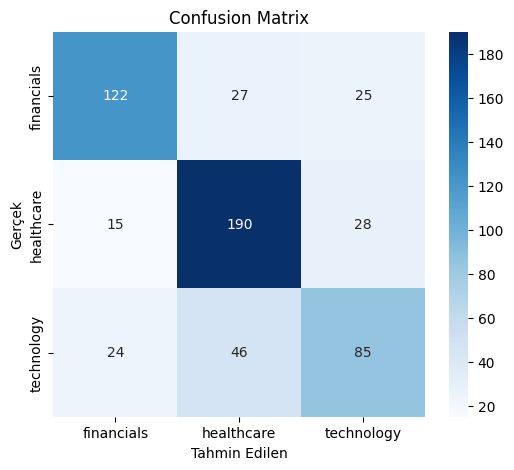

In [10]:
# Gerekli kütüphaneleri import edelim
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Veri setini bölelim
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Eğitim seti şekli:", X_train.shape)
print("Test seti şekli:", X_test.shape)

# RandomForest
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
print("RandomForestClassifier En İyi Parametreler:", grid_rf.best_params_)
print("RandomForest CV Skoru:", grid_rf.best_score_)

# XGBoost - Basitleştirilmiş versiyonu
base_xgb = XGBClassifier(
    random_state=42,
    objective='multi:softprob'
)
best_xgb = base_xgb.fit(X_train, y_train)
xgb_score = accuracy_score(y_test, best_xgb.predict(X_test))
print("XGBoost Test Skoru:", xgb_score)

# CatBoost
cat = CatBoostClassifier(random_state=42, verbose=0)
param_grid_cat = {
    'iterations': [50, 100, 200],
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_cat = GridSearchCV(cat, param_grid_cat, cv=5, scoring='accuracy', n_jobs=-1)
grid_cat.fit(X_train, y_train)
print("CatBoostClassifier En İyi Parametreler:", grid_cat.best_params_)
print("CatBoost CV Skoru:", grid_cat.best_score_)

# En iyi modeli seç
cv_scores = {
    'RandomForest': grid_rf.best_score_,
    'XGBoost': xgb_score,
    'CatBoost': grid_cat.best_score_
}
best_model_name = max(cv_scores, key=cv_scores.get)
print("\nEn iyi model:", best_model_name)

# En iyi modeli kullan
if best_model_name == 'RandomForest':
    best_model = grid_rf.best_estimator_
elif best_model_name == 'XGBoost':
    best_model = best_xgb
else:
    best_model = grid_cat.best_estimator_

# Model değerlendirme
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')

print("\nTest Seti Performans Metrikleri:")
print("Doğruluk (Accuracy):", accuracy)
print("Weighted F1 Skoru:", f1)
print("ROC-AUC:", roc_auc)
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix görselleştirme
plt.figure(figsize=(6,5))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.show()

# Hücre 11: Sektörel Benzerlik Analizi
Açıklama:
Yeni bir hisse senedi verisinden tsfresh ile öznitelik çıkarımı yapılarak, eğitilmiş modelin tahmin ettiği sektör benzerlik oranları hesaplanıyor.

In [15]:
import requests
import pandas as pd
import numpy as np
import yfinance as yf
import time
import pandas_ta as ta
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import impute

# Fonksiyon 1: Belirtilen sektör verisini çek (örneğin "real-estate" tireli)
def fetch_data(category, name):
    url = f"https://stockanalysis.com/stocks/{category}/{name}/"
    try:
        response = requests.get(url)
        response.raise_for_status()
        tables = pd.read_html(response.text)
        if tables:
            df = tables[0]
            print(f"{name.capitalize()} {category} verisi başarıyla çekildi.")
            return df
        else:
            print(f"{name.capitalize()} {category} verisi için tablo bulunamadı.")
            return pd.DataFrame()
    except Exception as e:
        print(f"{name.capitalize()} {category} verisi çekilirken hata: {e}")
        return pd.DataFrame()

# Fonksiyon 2: Tarihsel verileri çek (yfinance kullanılarak)
def fetch_historical_data_for_sector(sector_name, filename):
    filepath = f"data/stock_sectors/{filename}"
    try:
        df_sector = pd.read_csv(filepath)
    except Exception as e:
        print(f"Dosya okunamadı: {filepath} hata: {e}")
        return pd.DataFrame()
    if "Symbol" not in df_sector.columns:
        print("CSV dosyasında 'Symbol' sütunu bulunamadı!")
        return pd.DataFrame()
    symbols = df_sector["Symbol"].dropna().unique()
    master_data = pd.DataFrame()
    for symbol in symbols:
        try:
            print(f"{symbol} için tarihsel veri çekiliyor... (Sektör: {sector_name})")
            ticker = yf.Ticker(symbol)
            df_hist = ticker.history(start='2005-01-01')
            if df_hist.empty:
                print(f"{symbol} için veri bulunamadı.")
                continue
            df_hist.reset_index(inplace=True)
            df_hist["Symbol"] = symbol
            df_hist["Sector"] = sector_name
            master_data = pd.concat([master_data, df_hist], ignore_index=True)
            time.sleep(0.2)  # API uyarılarından kaçınmak için
        except Exception as e:
            print(f"{symbol} için veri çekilirken hata: {e}")
    return master_data

# Fonksiyon 3: Veri temizleme (eksik değer kontrolü)
def clean_data(df):
    cleaned_df = pd.DataFrame()
    symbols = df["Symbol"].unique()
    for symbol in symbols:
        df_symbol = df[df["Symbol"] == symbol].copy()
        total = df_symbol.shape[0]
        missing_ratio = df_symbol["Close"].isnull().sum() / total
        if missing_ratio < 0.1:
            df_symbol.fillna(method='ffill', inplace=True)
            df_symbol.fillna(method='bfill', inplace=True)
            cleaned_df = pd.concat([cleaned_df, df_symbol], ignore_index=True)
        else:
            print(f"{symbol}: Çok fazla eksik veri (%{missing_ratio*100:.2f}). Veri setinden çıkarıldı.")
    return cleaned_df

# Fonksiyon 4: Aylık teknik özelliklerin hesaplanması
def calculate_monthly_features(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    # Teknik göstergeler
    df['RSI'] = ta.rsi(df['Close'], length=14)
    macd_df = ta.macd(df['Close'])
    df['MACD'] = macd_df['MACD_12_26_9']
    df['Volatility'] = df['Close'].rolling(window=21).std()
    df['Momentum'] = df['Close'] - df['Close'].shift(10)

    monthly = pd.DataFrame()
    symbols = df['Symbol'].unique()
    for symbol in symbols:
        df_symbol = df[df['Symbol'] == symbol].copy()
        df_symbol.set_index('Date', inplace=True)
        monthly_data = pd.DataFrame()
        monthly_data['Close'] = df_symbol['Close'].resample('ME').last()
        monthly_data['RSI'] = df_symbol['RSI'].resample('ME').last()
        monthly_data['MACD'] = df_symbol['MACD'].resample('ME').last()
        monthly_data['Momentum'] = df_symbol['Momentum'].resample('ME').last()
        monthly_data['Volatility'] = df_symbol['Volatility'].resample('ME').mean()
        monthly_data['Monthly_Return'] = monthly_data['Close'].pct_change()
        monthly_data['Log_Return'] = np.log1p(monthly_data['Monthly_Return'])
        monthly_data.reset_index(inplace=True)
        monthly_data['Symbol'] = symbol
        sector_val = df_symbol['Sector'].unique()[0] if len(df_symbol['Sector'].unique()) == 1 else "Mixed"
        monthly_data['Sector'] = sector_val
        monthly = pd.concat([monthly, monthly_data], ignore_index=True)
    return monthly

# Fonksiyon 5: Her sembol için tsfresh ile öznitelik çıkarımını yapıp, sektör benzerlik tahmini
def analyze_sector_similarity_individual(real_estate_data, trained_model, label_encoder):
    results = []
    for symbol in real_estate_data["Symbol"].unique():
        symbol_data = real_estate_data[real_estate_data["Symbol"] == symbol]
        symbol_data = symbol_data.dropna(subset=['Log_Return', 'RSI', 'MACD', 'Momentum', 'Volatility'])
        if symbol_data.empty:
            continue
        melted_data = pd.melt(symbol_data,
                              id_vars=['Symbol', 'Date'],
                              value_vars=['Log_Return', 'RSI', 'MACD', 'Momentum', 'Volatility'],
                              var_name='feature',
                              value_name='value')
        features = extract_features(melted_data,
                                    column_id='Symbol',
                                    column_sort='Date',
                                    column_kind='feature',
                                    column_value='value',
                                    default_fc_parameters=MinimalFCParameters(),
                                    impute_function=impute)
        features.reset_index(inplace=True)
        if "Symbol" not in features.columns:
            features["Symbol"] = symbol
        for col in features.columns:
            if col != "Symbol":
                features[col] = pd.to_numeric(features[col], errors='coerce')
        features.fillna(0, inplace=True)
        X_new = features.drop(columns=['Symbol'])
        probabilities = trained_model.predict_proba(X_new)
        sectors = label_encoder.inverse_transform(np.arange(probabilities.shape[1]))
        similarity_df = pd.DataFrame(probabilities, columns=sectors)
        similarity_df.insert(0, 'Symbol', symbol)
        results.append(similarity_df)
    if results:
        return pd.concat(results, ignore_index=True)
    else:
        return pd.DataFrame()

# ---------------------------
# Ana Pipeline
# ---------------------------
# 1. Real Estate verisini çek
real_estate_df = fetch_data("sector", "real-estate")
if not real_estate_df.empty:
    # Veriyi CSV'ye kaydedelim
    real_estate_df.to_csv("data/stock_sectors/real_estate.csv", index=False)
else:
    print("Real Estate verisi çekilemedi!")

# 2. Tarihsel verileri çekelim
real_estate_data = fetch_historical_data_for_sector("real_estate", "real_estate.csv")
if not real_estate_data.empty:
    real_estate_data.to_csv("data/stock_sectors/real_estate_historical.csv", index=False)
    print("Real Estate sektör tarihsel verisi kaydedildi.\n")
else:
    print("Real Estate tarihsel verisi çekilemedi!\n")

# 3. Veri temizleme
real_estate_data_clean = clean_data(real_estate_data) if not real_estate_data.empty else pd.DataFrame()

# 4. Aylık özellik hesaplama
real_estate_monthly = calculate_monthly_features(real_estate_data_clean) if not real_estate_data_clean.empty else pd.DataFrame()
print("Aylık verilerden ilk birkaç satır:")
print(real_estate_monthly.head())

# 5. İlk 5 benzersiz hisse senedini seçip sektör benzerlik analizi yapalım
if not real_estate_monthly.empty:
    first_5_symbols = real_estate_monthly["Symbol"].unique()[:5]
    real_estate_first5 = real_estate_monthly[real_estate_monthly["Symbol"].isin(first_5_symbols)]


    similarity_results = analyze_sector_similarity_individual(real_estate_first5, best_model, le)

    print("Real Estate Sektöründeki İlk 5 Hissenin Sektör Benzerlik Sonuçları:")
    print(similarity_results)
else:
    print("Real Estate'e ait aylık veri bulunamadı.")


Real-estate sector verisi başarıyla çekildi.
PLD için tarihsel veri çekiliyor... (Sektör: real_estate)
WELL için tarihsel veri çekiliyor... (Sektör: real_estate)
EQIX için tarihsel veri çekiliyor... (Sektör: real_estate)
AMT için tarihsel veri çekiliyor... (Sektör: real_estate)
SPG için tarihsel veri çekiliyor... (Sektör: real_estate)
DLR için tarihsel veri çekiliyor... (Sektör: real_estate)
PSA için tarihsel veri çekiliyor... (Sektör: real_estate)
O için tarihsel veri çekiliyor... (Sektör: real_estate)
CBRE için tarihsel veri çekiliyor... (Sektör: real_estate)
CCI için tarihsel veri çekiliyor... (Sektör: real_estate)
EXR için tarihsel veri çekiliyor... (Sektör: real_estate)
VICI için tarihsel veri çekiliyor... (Sektör: real_estate)
AVB için tarihsel veri çekiliyor... (Sektör: real_estate)
CSGP için tarihsel veri çekiliyor... (Sektör: real_estate)
VTR için tarihsel veri çekiliyor... (Sektör: real_estate)
EQR için tarihsel veri çekiliyor... (Sektör: real_estate)
IRM için tarihsel veri ç

ERROR:yfinance:Could not get exchangeTimezoneName for ticker 'SITC' reason: 'chart'
ERROR:yfinance:$SITC: possibly delisted; no timezone found


SITC için veri bulunamadı.
KREF için tarihsel veri çekiliyor... (Sektör: real_estate)
BRSP için tarihsel veri çekiliyor... (Sektör: real_estate)
PLYM için tarihsel veri çekiliyor... (Sektör: real_estate)
ORC için tarihsel veri çekiliyor... (Sektör: real_estate)
GOOD için tarihsel veri çekiliyor... (Sektör: real_estate)
WSR için tarihsel veri çekiliyor... (Sektör: real_estate)
TRTX için tarihsel veri çekiliyor... (Sektör: real_estate)
DHC için tarihsel veri çekiliyor... (Sektör: real_estate)
STRW için tarihsel veri çekiliyor... (Sektör: real_estate)
CTO için tarihsel veri çekiliyor... (Sektör: real_estate)
FRPH için tarihsel veri çekiliyor... (Sektör: real_estate)
RMR için tarihsel veri çekiliyor... (Sektör: real_estate)
FPI için tarihsel veri çekiliyor... (Sektör: real_estate)
CHCT için tarihsel veri çekiliyor... (Sektör: real_estate)
OLP için tarihsel veri çekiliyor... (Sektör: real_estate)
GMRE için tarihsel veri çekiliyor... (Sektör: real_estate)
NYMT için tarihsel veri çekiliyor...

Aylık verilerden ilk birkaç satır:
                       Date      Close        RSI      MACD  Momentum  \
0 2005-01-31 00:00:00-05:00  19.215843  26.740565       NaN -0.552275   
1 2005-02-28 00:00:00-05:00  20.036497  50.610540 -0.015509 -0.015478   
2 2005-03-31 00:00:00-05:00  19.510040  46.197068 -0.205857 -0.237425   
3 2005-04-30 00:00:00-04:00  20.361259  63.562737  0.175455  0.882557   
4 2005-05-31 00:00:00-04:00  21.050587  57.676808  0.226206  0.083565   

   Volatility  Monthly_Return  Log_Return Symbol       Sector  
0         NaN             NaN         NaN    PLD  real_estate  
1    0.400409        0.042707    0.041820    PLD  real_estate  
2    0.364857       -0.026275   -0.026626    PLD  real_estate  
3    0.306920        0.043630    0.042705    PLD  real_estate  
4    0.410468        0.033855    0.033294    PLD  real_estate  


Feature Extraction: 100%|██████████| 5/5 [00:00<00:00, 1066.87it/s]

Real Estate Sektöründeki İlk 5 Hissenin Sektör Benzerlik Sonuçları:
  Symbol  financials  healthcare  technology
0    PLD    0.803996    0.039514    0.156490
1   WELL    0.617556    0.210356    0.172088
2   EQIX    0.420425    0.175404    0.404171
3    AMT    0.223931    0.471690    0.304380
4    SPG    0.719878    0.111656    0.168466


Feature Extraction: 100%|██████████| 5/5 [00:00<00:00, 976.83it/s]


Bütün Real Estate'in Ortalama Sektör Benzerlik Oranları:
financials    0.576070
healthcare    0.220245
technology    0.203685
dtype: float64


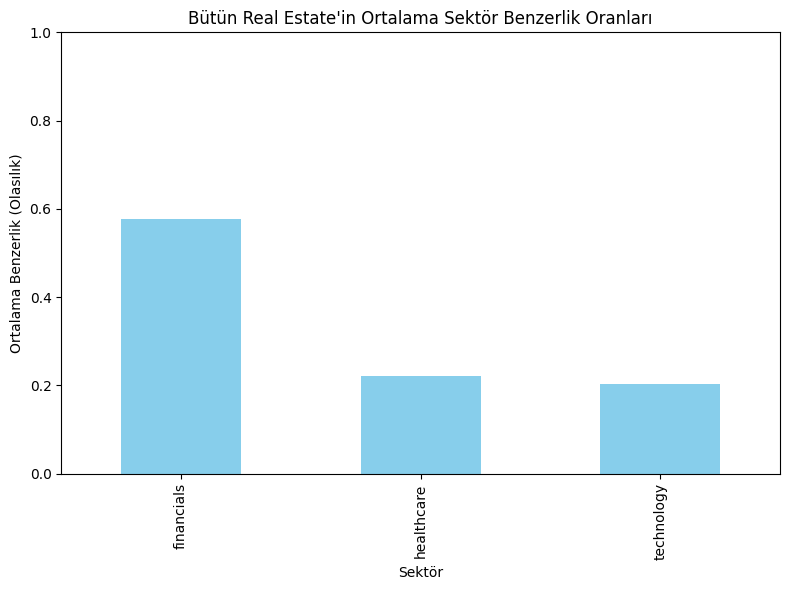

In [23]:
import warnings
import logging

# Tsfresh uyarılarını logging üzerinden bastırmak için:
logging.getLogger("tsfresh.feature_extraction.settings").setLevel(logging.ERROR)

# Tüm diğer uyarıları kapatmak için:
warnings.filterwarnings("ignore")


all_similarity = analyze_sector_similarity_individual(real_estate_monthly, best_model, le)


aggregate_similarity = all_similarity.drop(columns='Symbol').mean()
print("Bütün Real Estate'in Ortalama Sektör Benzerlik Oranları:")
print(aggregate_similarity)

# Ortalama benzerlik oranlarını bar grafiği ile görselleştirelim:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
aggregate_similarity.plot(kind='bar', color='skyblue')
plt.title("Bütün Real Estate'in Ortalama Sektör Benzerlik Oranları")
plt.xlabel("Sektör")
plt.ylabel("Ortalama Benzerlik (Olasılık)")
plt.ylim(0,1)
plt.tight_layout()
plt.show()


In [16]:
import joblib

# Modeli kaydet
model_filename = "best_model.pkl"
joblib.dump(best_model, model_filename)

print(f"✅ En iyi model '{model_filename}' olarak kaydedildi.")


✅ En iyi model 'best_model.pkl' olarak kaydedildi.
